# Maximum Ozone Hole Extent
Welcome to the **Maximum Ozone Hole Extent** notebook! In this notebook, we will provide a more complex example of how to plot data onto a 3D model of the Earth using the **accessvis** package. 

In this notebook we will plot both the historical and predicted ozone hole size.
* Animate the ozone hole every day for one year.
* Calculate the size of the ozone hole.
  * This includes calculating the area of each grid cell.
* Finding the day of the year where the ozone hole is largest.
* Animating this hole over time.

The data used is available in project p73 on gadi and takes about 5 minutes to run.

## Initial Setup

In [1]:
import accessvis
import os
import glob
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

Finding and pre-loading data to speed up the rest of the notebook (~5GB).

In [2]:
datadir = '/g/data/p73/archive/non-CMIP/CMORised/CCMI2022/CSIRO-ARCCSS/ACCESS-CM2-Chem/refD2/r1i1p1f1/Aday/toz/gn/v20220822/'
files = sorted(glob.glob(datadir + "*.nc"))
ds = xr.open_mfdataset(files, combine='nested', concat_dim="time")
for f in files:
    print(f)
ds.load()

/g/data/p73/archive/non-CMIP/CMORised/CCMI2022/CSIRO-ARCCSS/ACCESS-CM2-Chem/refD2/r1i1p1f1/Aday/toz/gn/v20220822/toz_Aday_ACCESS-CM2-Chem_refD2_r1i1p1f1_gn_19600101-20091231.nc
/g/data/p73/archive/non-CMIP/CMORised/CCMI2022/CSIRO-ARCCSS/ACCESS-CM2-Chem/refD2/r1i1p1f1/Aday/toz/gn/v20220822/toz_Aday_ACCESS-CM2-Chem_refD2_r1i1p1f1_gn_20100101-20591231.nc
/g/data/p73/archive/non-CMIP/CMORised/CCMI2022/CSIRO-ARCCSS/ACCESS-CM2-Chem/refD2/r1i1p1f1/Aday/toz/gn/v20220822/toz_Aday_ACCESS-CM2-Chem_refD2_r1i1p1f1_gn_20600101-21001231.nc


<xarray.Dataset> Size: 6GB
Dimensions:   (time: 51500, lat: 144, bnds: 2, lon: 192)
Coordinates:
  * time      (time) datetime64[ns] 412kB 1960-01-01T12:00:00 ... 2100-12-31T...
  * lat       (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon       (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (time, lat, bnds) float64 119MB -90.0 -88.75 -88.75 ... 88.75 90.0
    lon_bnds  (time, lon, bnds) float64 158MB 0.0 1.875 1.875 ... 358.1 360.0
    toz       (time, lat, lon) float32 6GB 0.003163 0.003164 ... 0.005004
Attributes: (12/45)
    Conventions:             CF-1.7
    activity_id:             CCMI2022
    activity_participation:  CCMI2022
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    ...                      ...
    variable_id:             toz
    variant_label:           r1i1p1f1
    version:                 v20220822
    license:                 CCMI2022 model data produced by CSIRO is license...
    cmor_version:            3.4.0
    tracking_id:             hdl:21.14100/c172e59b-9c50-44be-836c-6c44dd9a8e40

## Plot One Year
Below we are making a quick animation of the ozone hole throughout 2015.

You can clearly see the ozone hole change with the seasons.

In [3]:
lv = accessvis.plot_earth(texture='bluemarble', waves=True, background='black', vertical_exaggeration=30)
lv.set_properties(diffuse=0.6, ambient=0.85, specular=0.25, shininess=0.03, light=[1,1,0.98,1], lightpos=[0,0,10000,1])

threshold = 220 * 1e-5 #220 DU threshold converted to M

colourmap='plasma'
cmap = lv.colourmap(colourmap, range=(220, 550))
cb = lv.colourbar()


In [4]:
filename = 'ozone_one_year.mp4'

with lv.video(filename=filename, quality=4, resolution=(600,600), width=600, height=600, params="autoplay") as v:
    for i in tqdm(range(365)):
        date = np.datetime64('2015-01-01T12:00:00') + np.timedelta64(i, 'D')
        timepoint = ds['toz'].sel(time=date, method='nearest') # finding the corrosponding data for that day.
        timepoint = np.roll(timepoint, timepoint.shape[1] // 2, axis=1) * 1e5 # rotating the data so it lines up with the earth correctly.
        colours = accessvis.array_to_rgba(timepoint, colourmap=colourmap, minimum=220,maximum=550, flip=True, opacity=0.8) # converting to colours
        accessvis.update_earth_values(lv, dataMode=0, data=colours) # Overlaying the data onto the earth

        # A static earth is a little bit boring. Lets move it as well.
        lv.reset()
        lv.rotate('y', i)
        lv.rotate('x',-80)
        
        lv.title(f'Ozone - {date}')
        lv.render()

Output #0, mp4, to 'ozone_one_year.mp4':
  Stream #0:0: Unknown: none


  0%|          | 0/365 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

## Calculating Grid Cell Area
Below we are getting an approximate area of each grid cell.

In [5]:
def calculate_area(lat_start, lat_delta, lon_delta):
    # Area based on https://en.wikipedia.org/wiki/Spherical_segment where h=R(sin(lat1)-sin(lat2))
    R = 6371009  # radius earth meters
    area = 2 * np.pi * (R ** 2) * (
                np.sin(np.deg2rad(lat_start)) - np.sin(np.deg2rad(lat_start + lat_delta))) * lon_delta / 360
    return np.abs(area)


def make_grid_area(ds, lat_name='lat', lon_name='lon'):
    lat = ds[lat_name]
    min_lat = float(lat.min())
    max_lat = float(lat.max())
    delta_lat = abs(float(lat[0] - lat[1]))

    lon = ds[lon_name]
    min_lon = float(lon.min())
    max_lon = float(lon.max())
    delta_lon = abs(float(lon[0] - lon[1]))

    lon_grid, lat_grid = np.meshgrid(
        np.arange(min_lon, max_lon + 0.0000001, delta_lon),
        np.arange(min_lat, max_lat + 0.0000001, delta_lat)
    )

    grid = calculate_area(lat_grid, lat_delta=delta_lat, lon_delta=delta_lon)

    grid_nc = xr.DataArray(grid, coords={'lat': lat_grid[:, 1], 'lon': lon_grid[1, :]}, dims=['lat', 'lon'])
    return grid_nc

grid_nc = make_grid_area(ds)

Sanity check: grid squares should be smaller near the poles

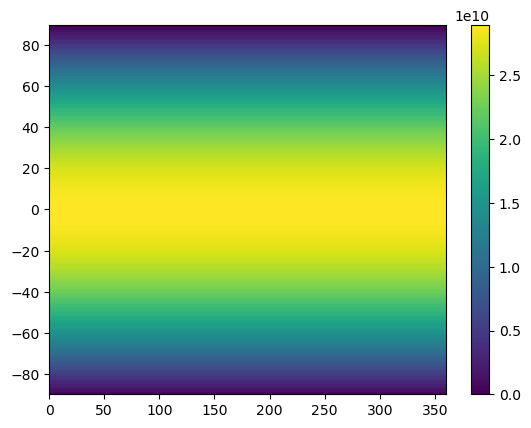

In [6]:
fig, ax = plt.subplots()
c = ax.pcolormesh(grid_nc['lon'], grid_nc['lat'], grid_nc)
fig.colorbar(c, ax=ax)
plt.show()

Sanity check: Earth's surface area: 510.1 million km²

In [7]:
earth_sa = 510.1
m2 = np.array(grid_nc).sum()
km2 = 1e-6 * m2
Mkm2 = 1e-6 * km2
error = abs(earth_sa - Mkm2)
print(f"{m2} m\n{km2} km²\n{Mkm2} million km²\nError {round(error / Mkm2 * 100, 2)}%")
#Check within ~1% tolerance
assert(error < (earth_sa * 0.01))

510035566625638.0 m
510035566.62563795 km²
510.0355666256379 million km²
Error 0.01%


## Daily Ozone Hole Area
* We make a mask of the ozone hole - A cell is a part of the ozone hole when it is at 220 Dobson units or lower.
* We multiply this by the area of each cell and sum to get the total area of the hole.
* We adjust units for readability.

In [9]:
def get_hole_all_time(threshold=220*1e-5):
    below = ds['toz'] < threshold # Finding cells in of the ozone hole 
    hole_area = grid_nc * below
    m2 = hole_area.sum(dim=('lat', 'lon')) # Total Area
    km2 = 1e-6 * m2
    Mkm2 = 1e-6 * km2

    return Mkm2

hole_size_daily = get_hole_all_time()

## Annual Maximum Ozone Hole Area
Below we calculate the maximum hole area each year and plot this

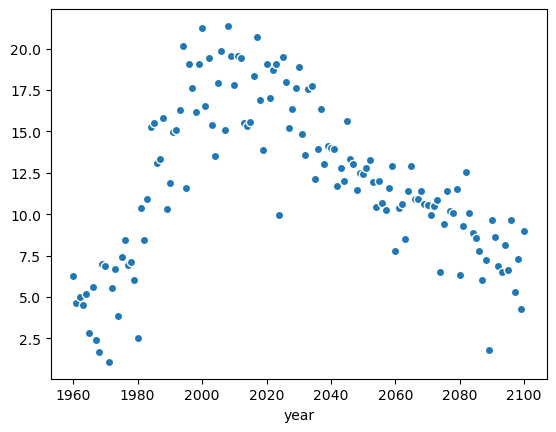

In [10]:
max_hole_size = hole_size_daily.groupby('time.year').max()
max_hole_size.plot.scatter()

## Calculating the Specific Date When Annual Maximum Occurs

In [11]:
max_hole_size_date = {}

for i in tqdm(max_hole_size):
    filter_by_year = hole_size_daily.sel(time=hole_size_daily.time.time.dt.year == i.year)
    diffs = np.abs(filter_by_year.values - np.array(i))
    nearest_index = diffs.argmin()
    max_date = filter_by_year.time[nearest_index].values

    max_hole_size_date[int(i.year)] = max_date

  0%|          | 0/141 [00:00<?, ?it/s]

## Animation of the Annual Maximum Ozone Hole
We iterate through all years, plotting the largest ozone hole for that year.

#### Plotting the hole itself

In [12]:
lv = accessvis.plot_earth(texture='bluemarble', waves=True, background='black', vertical_exaggeration=20)
lv.set_properties(diffuse=0.6, ambient=0.85, specular=0.25, shininess=0.03, light=[1,1,0.98,1], lightpos=[0,0,10000,1])

threshold = 220e-5 #220 DU threshold converted to M

filename = 'max_ozone_hole.mp4'
print(filename)

max_ozone_hole.mp4


In [13]:
with lv.video(filename=filename, quality=4, resolution=(600,600), width=600, height=600, params="autoplay") as v:
    for year, date in tqdm(sorted(max_hole_size_date.items())):
        timepoint = ds['toz'].sel(time=date, method='nearest')
        timepoint = np.roll(timepoint, timepoint.shape[1] // 2, axis=1)
        hole_mask =  (0.9*(timepoint<threshold))
        
        colours = accessvis.array_to_rgba(hole_mask, colourmap='coolwarm', flip=True, opacitymap=hole_mask)
        accessvis.update_earth_values(lv, dataMode=0, data=colours)
        
        lv.reset()
        lv.rotate('y', year % 360)
        lv.rotate('x',-80)
        
        lv.title(f'Largest Ozone Hole - {year}')
        lv.render()

  0%|          | 0/141 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

#### Plotting the Ozone Concentration

In [14]:
lv = accessvis.plot_earth(texture='bluemarble', waves=True, background='black', vertical_exaggeration=30)
lv.set_properties(diffuse=0.6, ambient=0.85, specular=0.25, shininess=0.03, light=[1,1,0.98,1], lightpos=[0,0,10000,1])

threshold = 220 * 1e-5 #220 DU threshold converted to M

colourmap='plasma'
cmap = lv.colourmap(colourmap, range=(220, 550))
cb = lv.colourbar()

In [15]:
filename = 'max_ozone_level.mp4'
print(filename)

with lv.video(filename=filename, quality=4, resolution=(600,600), width=600, height=600, params="autoplay") as v:
    for year, date in tqdm(sorted(max_hole_size_date.items())):
        timepoint = ds['toz'].sel(time=date, method='nearest')
        timepoint = np.roll(timepoint, timepoint.shape[1] // 2, axis=1) * 1e5
        colours = accessvis.array_to_rgba(timepoint, colourmap=colourmap, minimum=220,maximum=550, flip=True, opacity=0.8)
        accessvis.update_earth_values(lv, dataMode=0, data=colours)

        lv.reset()
        lv.rotate('y', year % 360)
        lv.rotate('x',-80)
        
        lv.title(f'Ozone Maximum - {year}')
        lv.render()

max_ozone_level.mp4


  0%|          | 0/141 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>